In [9]:
import pathlib
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define dataset path
dataset_path = pathlib.Path("C:/Users/PC/Downloads/mri-ct/Dataset")

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images
    transforms.ToTensor(),  # Convert images to tensors
])

# Load dataset
dataset = datasets.ImageFolder(root=str(dataset_path), transform=transform)

# Split dataset into training (80%) and validation (20%)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Print class labels to verify structure
print("Class labels mapping:", dataset.class_to_idx)
print(f"Total images: {len(dataset)} | Train: {len(train_dataset)} | Validation: {len(val_dataset)}")



Class labels mapping: {'CT_scan': 0, 'MRI_images': 1}
Total images: 9618 | Train: 7694 | Validation: 1924


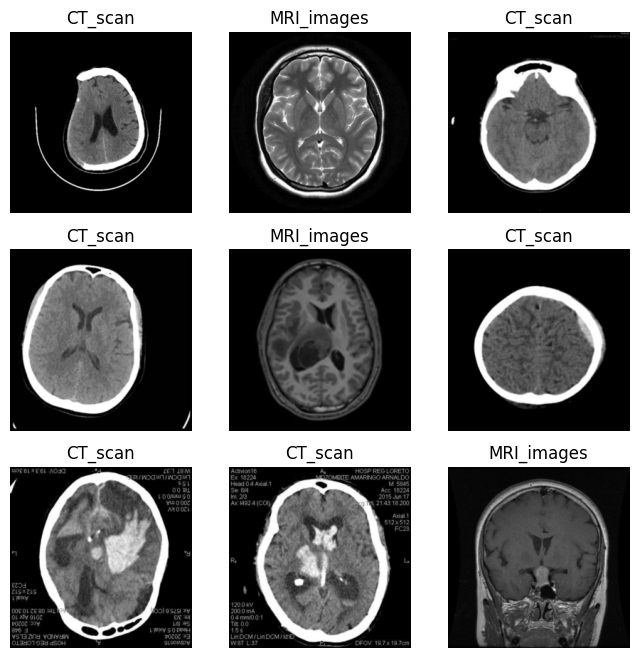

In [10]:
# Visualize sample images
import matplotlib.pyplot as plt

# Get one batch of images and labels
images, labels = next(iter(train_loader))  # Use an iterator to get the first batch

# Define class names from dataset
class_names = dataset.classes  # Extract class names

# Plot the first 9 images
plt.figure(figsize=(8, 8))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].permute(1, 2, 0).numpy())  # Convert tensor to numpy image
    plt.title(class_names[labels[i].item()])  # Convert tensor label to int
    plt.axis("off")

plt.show()


In [13]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model.to(device)

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


# Define a simple CNN model
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = torch.flatten(x, start_dim=1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Instantiate model
num_classes = len(dataset.classes)
model = CNNModel(num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Print model summary
print(model)


CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=131072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [15]:

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Print optimizer and loss function to confirm setup
print("Model moved to:", device)
print("Loss Function:", criterion)
print("Optimizer:", optimizer)


Model moved to: cpu
Loss Function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


Epoch 1/5 - Train Loss: 0.1319, Train Acc: 0.9593 - Val Loss: 0.0049, Val Acc: 0.9984
Epoch 2/5 - Train Loss: 0.0166, Train Acc: 0.9957 - Val Loss: 0.0406, Val Acc: 0.9875
Epoch 3/5 - Train Loss: 0.0116, Train Acc: 0.9975 - Val Loss: 0.0029, Val Acc: 0.9990
Epoch 4/5 - Train Loss: 0.0260, Train Acc: 0.9929 - Val Loss: 0.0069, Val Acc: 0.9979
Epoch 5/5 - Train Loss: 0.0125, Train Acc: 0.9962 - Val Loss: 0.0025, Val Acc: 0.9995
Training complete!


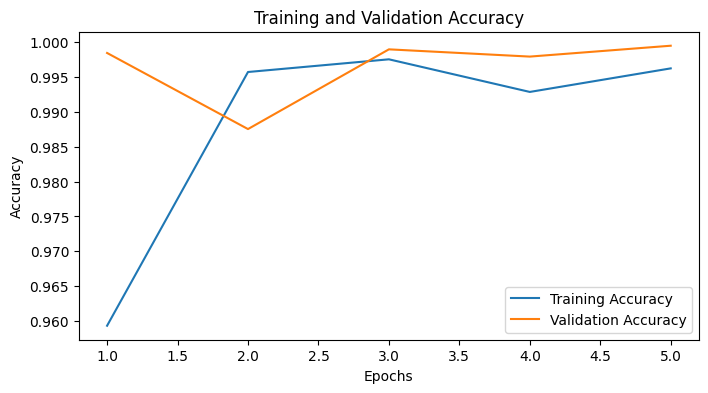

In [16]:
import torch
import matplotlib.pyplot as plt

# Training settings
epochs = 5
history = {"train_acc": [], "val_acc": [], "train_loss": [], "val_loss": []}

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move to GPU if available

        optimizer.zero_grad()  # Reset gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    history["train_acc"].append(train_acc)
    history["train_loss"].append(train_loss)

    # Validation step
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total
    history["val_acc"].append(val_acc)
    history["val_loss"].append(val_loss)

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {history['train_loss'][-1]:.4f}, Train Acc: {train_acc:.4f} - "
          f"Val Loss: {history['val_loss'][-1]:.4f}, Val Acc: {val_acc:.4f}")

print("Training complete!")

# Plot training history
plt.figure(figsize=(8, 4))
plt.plot(range(1, epochs + 1), history['train_acc'], label="Training Accuracy")  
plt.plot(range(1, epochs + 1), history['val_acc'], label="Validation Accuracy")  
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")
plt.show()


In [17]:
# Save the trained model
torch.save(model.state_dict(), "brain_tumor_model.h5")
print("Model saved successfully!")

Model saved successfully!
